In [1]:
import sys
sys.version

'3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]'

In [3]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc

from tqdm import tqdm
from matplotlib import pyplot as plt

## Реализуем крестики-нолики

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [54]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [236]:
class Strategy():
    def __init__(self, epsilon=0.1):
        self.Q = {}
        self.epsilon = epsilon
        self.game_states = []
        print('here')
        pass
    
    def getAction(self, s, num_actions, pi2=None, init_zero=False):
        #print(s)
        free_mask = np.array([1 if x == '1' else 0 for x in s])
        #print(s, free_mask, self.Q) 
        if s not in self.Q:
            actions_array = np.ones(num_actions) 
            actions_array = actions_array/sum(actions_array)
            #print('aa', actions_array)
            self.Q[s] = actions_array
            action = np.random.randint(num_actions)
            self.game_states.append([s,action])
            return action
            
        res_action = np.argmax(self.Q[s])
        self.game_states.append([s,res_action])
        return  res_action if np.random.rand() > self.epsilon else np.random.randint(num_actions) 

    def getActionGreedy(self, s, num_actions, pi2=None, init_zero=False):
        
        free_mask = np.array([1 if x == '1' else 0 for x in s])
        #print(s, free_mask, self.Q) 
        if s not in self.Q:
            actions_array = np.ones(num_actions) 
            actions_array = actions_array/sum(actions_array)
            #print('aa', actions_array)
            self.Q[s] = actions_array
            action = np.random.randint(num_actions)
            self.game_states.append([s,action])
            return action
            
           
        res_action = np.argmax(self.Q[s])
        self.game_states.append([s,res_action])
        return res_action
    
    def updateQ(self, s, a, goal, num_actions, alpha=0.1):
        print(self.game_states)
        if s not in self.Q:
            self.Q[s] = np.zeros(num_actions)
        self.Q[s][a] += alpha * (goal - self.Q[s][a])
    def updateQs(self, reward, alpha=0.1):
        #print(self.game_states, reward)
        for n, qn in enumerate(reversed(self.game_states)):
            new_val =  max(0, self.Q[qn[0]][qn[1]] +  alpha * reward / (10 * (n+1)))
            self.Q[qn[0]][qn[1]] = new_val
            self.Q[qn[0]] = self.Q[qn[0]]/np.sum(self.Q[qn[0]])
        self.game_states = []
        #if s not in self.Q:
        #    self.Q[s] = np.zeros(num_actions)
        #self.Q[s][a] += alpha * (goal - self.Q[s][a])

In [250]:
def plot_board(env, pi, showtext=True, verbose=True):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=20, horizontalalignment='center', verticalalignment='center', color="w" )
            else:
                ax.text( a[1] , a[0] , "???", fontsize=20, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi)
    if random:
        return np.random.randint(len(actions))
    else:
        if verbose:
            if pi is not None and s in pi.Q:
                for i,a in enumerate(actions):
                    print(i, a, pi.Q[s][i])
            else:
                print("Стратегия не знает, что делать...")
        return pi.getActionGreedy(s, len(actions))

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose)
        observation, reward, done, info = env.step(actions[a])
        if verbose:
            env.printBoard()
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False)

In [238]:
mystr_x = Strategy()
mystr_o = Strategy()

here
here


In [281]:
def get_action(env, pi, s, actions, random=False, verbose=True, mode = 'greedy'):
    if random:
        return np.random.randint(len(actions))
    else:
        if mode == 'greedy':
            return pi.getActionGreedy(s, len(actions))
        else:
            return pi.getAction(s, len(actions))
    
def play_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=False, n_epochs=10000, mode = 'learn'):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_action(env, pi1, s, actions, random=random_crosses, verbose=verbose, mode=mode)
        else:
            a = get_action(env, pi2, s, actions, random=random_naughts, verbose=verbose, mode=mode)
        observation, reward, done, info = env.step(actions[a])
    return  observation, reward, done, info
            
        



def train(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=False, n_epochs=10000, vlaidation_cnt = 1000):
    val_prc_hist = []
    for epoch in tqdm(range(n_epochs)):
        observation, reward, done, info = play_game(env, pi1, pi2, random_crosses=random_crosses, random_naughts=random_naughts, verbose=verbose, mode = 'learn')
            
        if pi1 is not None:    
            pi1.updateQs(reward)
        if pi2 is not None:  
            pi2.updateQs(-reward)
            
        if epoch % vlaidation_cnt == 0:
            x_win = 0
            y_win = 0
            for v in range(1000):
                observation, reward, done, info = play_game(env, pi1, pi2, random_crosses=random_crosses, random_naughts=random_naughts, mode = 'greedy')
                if reward == 1:
                    x_win += 1
                else:
                    y_win += 1
            cur_prc = x_win/(y_win +  x_win) * 100
            val_prc_hist.append(cur_prc)
            #print(f'epoch = {epoch} winrate = {cur_prc} %, {x_win}, {y_win}')
    return val_prc_hist
                    
        
            
            


here
here


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.83it/s]


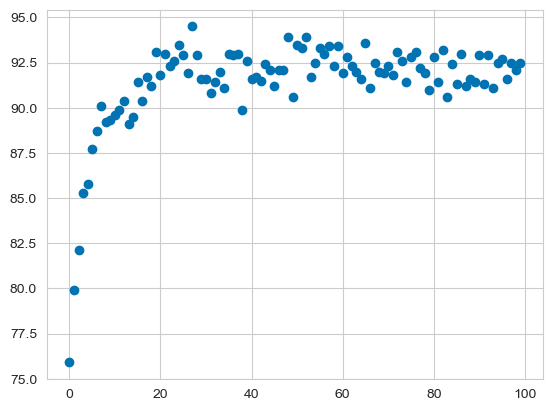

In [282]:

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
mystr_x = Strategy()
mystr_o = Strategy()
val_prc_hist = train(env, mystr_x, None, random_crosses=False, random_naughts=True, verbose=False, n_epochs=10000, vlaidation_cnt = 100)

plt.scatter(range(len(val_prc_hist)),val_prc_hist)

here
here


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:50<00:00, 907.71it/s]


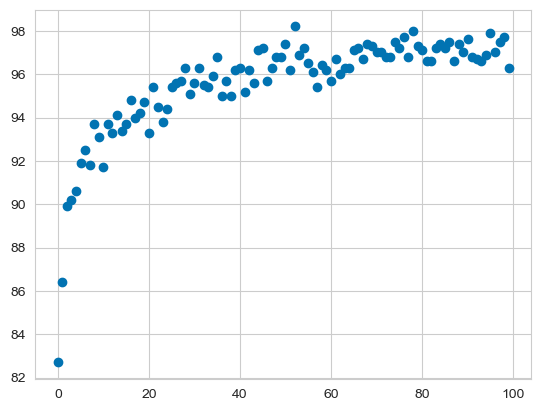

In [284]:
from tqdm import tqdm
from matplotlib import pyplot as plt
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)
mystr_x = Strategy()
mystr_o = Strategy()
val_prc_hist = train(env, mystr_x, None, random_crosses=False, random_naughts=True, verbose=False, n_epochs=100000, vlaidation_cnt = 1000)

plt.scatter(range(len(val_prc_hist)),val_prc_hist)

here
here


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:08<00:00, 233.34it/s]


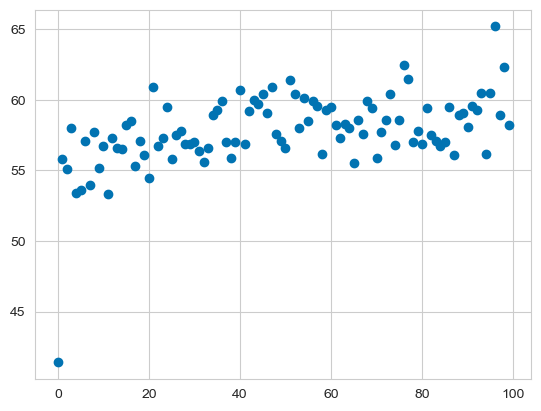

In [285]:
from tqdm import tqdm
from matplotlib import pyplot as plt
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)
mystr_x = Strategy()
mystr_o = Strategy()
val_prc_hist = train(env, mystr_x, None, random_crosses=False, random_naughts=True, verbose=False, n_epochs=100000, vlaidation_cnt = 1000)

plt.scatter(range(len(val_prc_hist)),val_prc_hist)

In [244]:
print(len(mystr_x.Q))

74560


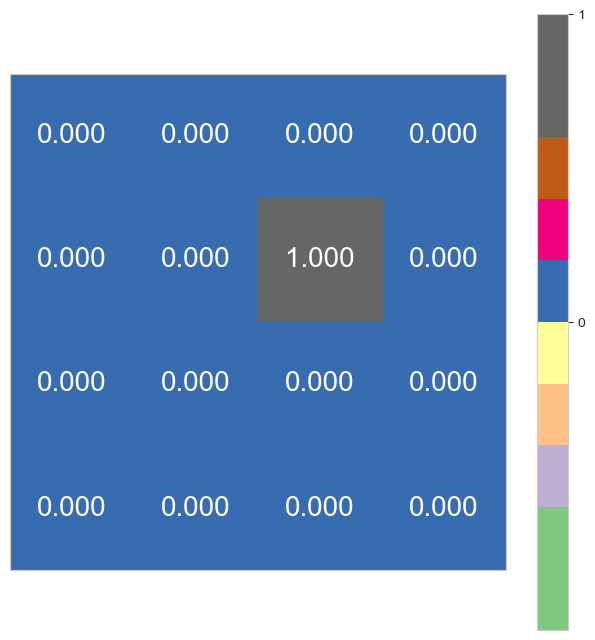

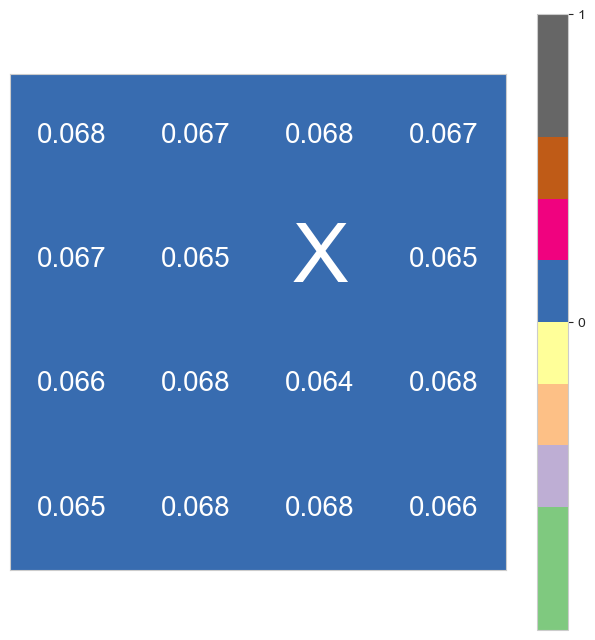

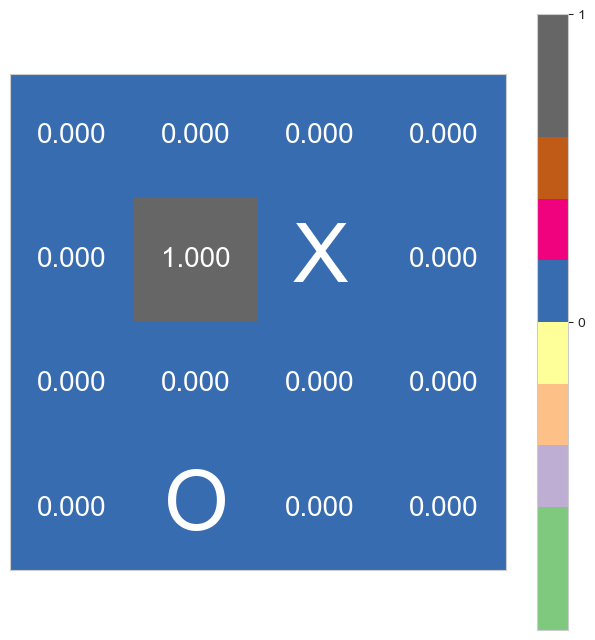

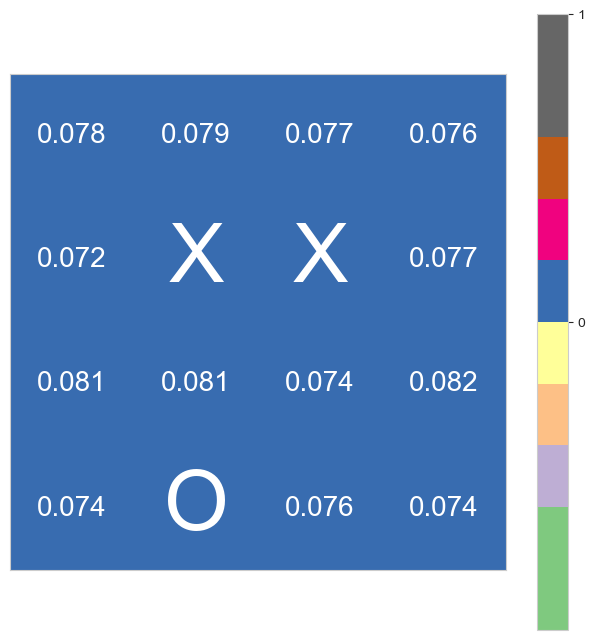

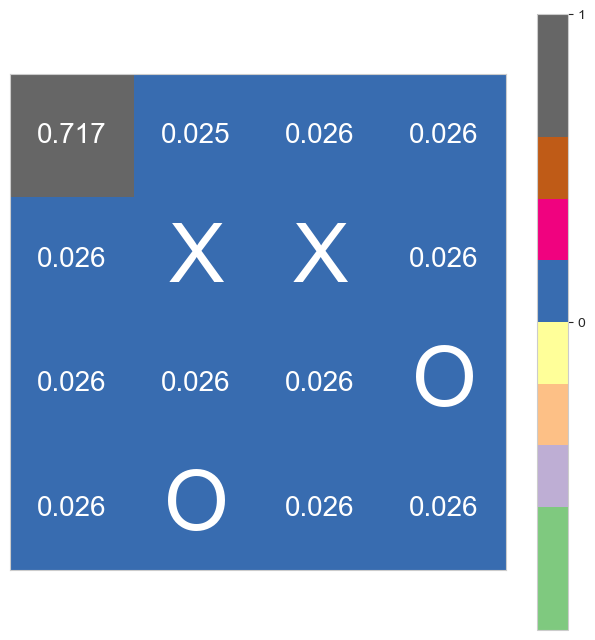

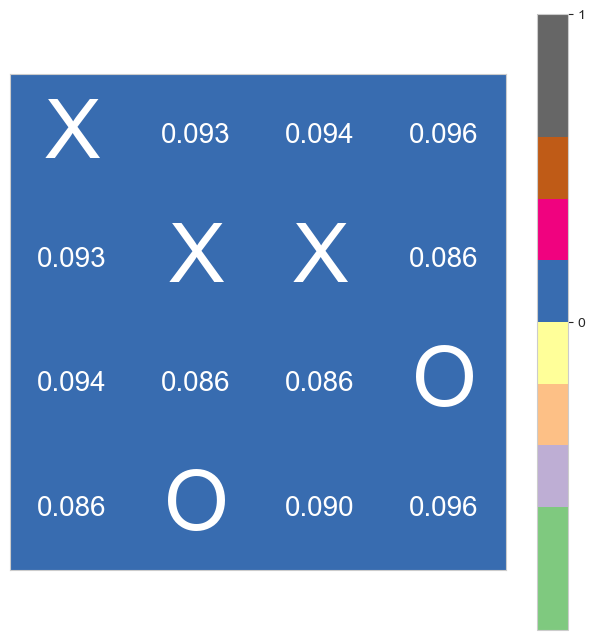

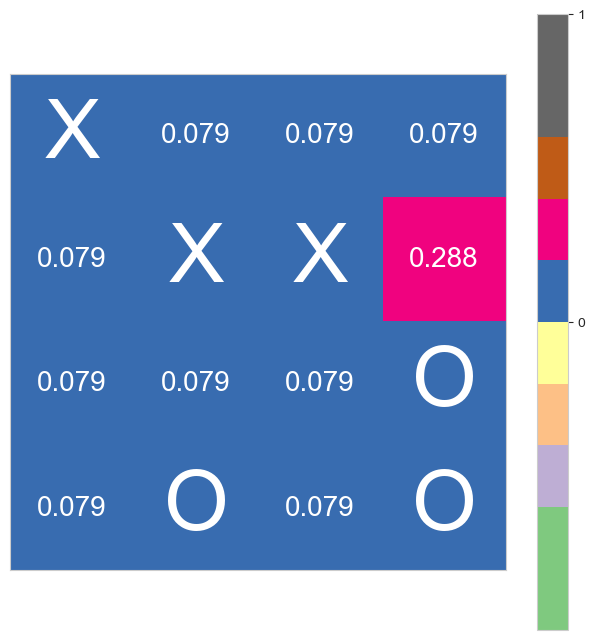

Крестики выиграли!


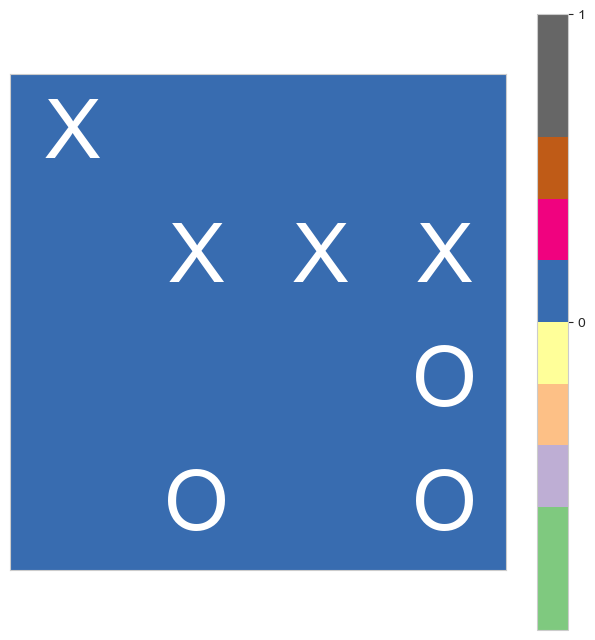

In [270]:
plot_test_game(env, mystr_x, mystr_o, random_crosses=False, random_naughts=False, verbose=False)